# Работу выполнили Жилин Андрей Игоревич и Зимин Андрей Валерьевич

# Импорт необходимых библиотек

In [204]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import matplotlib

from mpl_toolkits import mplot3d 
import seaborn as sns
from sklearn.model_selection import train_test_split

# Чтение Датасета

In [205]:
df = pd.read_csv("data/iris.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# 1 и 2 Задания

Текст заданий

1 Следует привести задачу классификации к бинарной. Т.е. рассматриваем
ирисы 2-х классов: Setosa и non-Setosa.


2 Из признаков оставляем только 2: sepal length и sepal width.

 Во-первых, оставляем только два признака, а также выделяем variety в отдельный df, если iris-setosa, то 1, если не выполняется равенство, то -1

Запишем формально
$ \[ F(x) = 
\begin{cases}

1, & \quad \text{ x is Iris-setosa} \\
-1  & \quad \text{ x is not Iris-setosa}
 
\end{cases}
\] $


In [206]:

y = pd.DataFrame()
X = df[["sepal_length", "sepal_width"]].to_numpy() #отбираем нужные признаки
y['variety'] = df["variety"].apply(lambda x: int(x == "Iris-setosa") - int(x != "Iris-setosa")) #функция для 1 и -1
y = y[['variety']].to_numpy() #переводим в numpy так как наш градиентный спуск работает с нампаем

In [207]:
X.shape #проверяем корректность

(150, 2)

In [208]:
y.shape #проверяем корректность

(150, 1)

In [209]:
np.unique(y) #проверяем корректность

array([-1,  1])

# Наш градиентный спуск

Сразу приведем реализацию градиентного спуска, он нам понадобится для минимизации функции ошибки, которая будет приведена после Метода Опорных Векторов

In [210]:
class GradientDescent:
    def __init__(self, train_x, train_y, h = 0.00005, eps=0.1, start_weights=None, logging=False, min_iterations=0, strategy="package", batch_size=1, lambda_=0, seed=19): #Добавил параметр лямбда для регуляризации
        np.random.seed(seed)
        #часть за данные ааа
        self.X = train_x #тренировочная выборка
        self.y = train_y #целевой признак
        self.strategy = strategy #название стратегии(package, mini-batch или stochastic)

        #метаданные
        self.width = len(train_x[0]) + 1 #ширина тренировочной выборки
        self.height = len(train_x) #высота тренировочной выборки
        
        #модель 
        self.batch_size = batch_size
        self.min_iterations = min_iterations
        self.h = h #шаг градиентного спуска h > 0
        self.lambda_ = lambda_ #коэффициент регуляризации
        self.eps = eps #точность градиентного спуска
        self.strategies = {'package': self.step_package, 'mini-batch': self.step_mini_batch, 'stochastic': self.step_mini_batch}
        if strategy == 'stochastic':
            self.batch_size = 1
        if start_weights is None: #задание стартовых весов
            self.w = np.full(self.width, 1)
        else:
            self.w = start_weights 

        self.X = np.concatenate((np.ones(self.height).reshape(-1, 1), self.X), axis=1) #фиктивная единица
        self.q = self.calc_q() # инициализируем ошибку

        #логи
        self.logging = logging #вывод логов в консоль
        self.qs = np.array([]) #величина ошибки
        self.curr_timer = None #текущий таймер
        self.timer = np.array([]) #массив для хранения время итераций
        self.iter_num = 0 #количество итераций
        
        
    def start_timer(self): #засечь время
        self.curr_timer = datetime.datetime.now()
    
    def stop_timer(self): #становить и записать время
        self.timer = np.append(self.timer, np.array(datetime.datetime.now() - self.curr_timer))

    def get_time(self): #общее время выполнения программы
        return self.timer.sum()

    def get_times(self): #получить время по шагам
        return self.timer
    
    def step_package(self): #шаг пакетного градиентного спуска
        
        self.w = self.w - self.h * self.grad()  #вычисляем градиент по пакету и меняем веса

    
    def step_mini_batch(self): #шаг стохастического градиентного спуска или mini-batch зависит от размера пакета
        
        idx = np.random.randint(self.height, size=self.batch_size) # формируем индексы пакета
        self.w = self.w - self.h * self.grad(self.X[idx, :], self.y[idx, :]) #вычисляем градиент по пакету и меняем веса
        
    
    def grad(self, X = None, y = None): #вычисление градиента по пакету(подходит для mini-batch, package и stochastic)
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y

        return (X.T.dot(X.dot(self.w) - y[:, 0]))*(2/self.height)

    def fit(self): #запуск градиентного спуска
        
        q = 2*self.q

        if self.logging:
            print("Величина ошибки на каждом шаге")

        while abs(self.q - q) > self.eps or self.iter_num < self.min_iterations:
            self.start_timer()
            q = self.q #переприсваеваем значение ошибки 
            self.strategies[self.strategy]()
            self.qs = np.append(self.qs, q) #запоминаем значение ошибки
            self.q = self.calc_q() #вычисление значение ошибки после новых весов
            self.iter_num += 1
            self.stop_timer()
            if self.logging:
                print(f"Шаг {self.iter_num}: ошибка {round(self.q, int(np.log(1/self.eps)/np.log(10)))};") #логи        
        if self.logging:
            print(f"Время работы: {self.get_time().microseconds/1000:.02f} мс")
        return self.w


    def calc_q(self):
        
        return np.mean((np.dot(self.X, self.w) - self.y[:, 0]) ** 2) #вычисление ошибки

    def predict(self, X):
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.dot(X, self.w).reshape(-1, 1) #предсказание
    
    

# Наш метод опорных векторов

Для него мы наследуемся от нашего градиентного спуска, так как почти все методы и атрибуты такие же, а те которые не подходят, мы переопределим в классе метода опорных векторов

Переопределим градиент, функцию вычисления ошибки и предсказания 

тут должен быть вывод функции ошибки(или хотя бы расчет градиента) а так же про линейность

In [211]:

class SupportVectorMachine(GradientDescent):#наследуемся от градиентного спуска
    
    def grad(self, X = None, y = None): #переопределяем вычисление градиента для нового класса svm
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y
        grad = np.zeros(self.width)
        for i in range(len(y)):
            if 1 - y[i]*np.dot(self.w, X[i, :]) > 0:
                grad += -y[i] * X[i, :]
                
        return 2*self.lambda_*self.w + grad #пока написал корявый градиент пускай хотя бы так считает
    
    
    def calc_q(self): #переопределяем функцию ошибки
        loss_result = self.lambda_*((self.w**2).sum())
        for i in range(self.height):
            loss_result += max(0, 1 - self.y[i]*np.dot(self.w, self.X[i, :])) #линейное ядро
        return loss_result[0]
    
    def predict(self, X): #переопределяем функцию предсказания
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.sign(np.dot(X, self.w).reshape(-1, 1)) #предсказание
    


# Наш класс для вычисления метрик

Повторение одних и тех же действий не очень полезно, особенно в программировании, потому необходимые вычисления метрик были вынесены в отдельный класс и будут вызываться как понадобится

Отдельно можно обратить внимание на метод get_hyper_p_2_params, здесь мы получаем уравнение двумерной гиперплоскости выражая один вес через другой, можно его расширить для больших размерностей, но пока задача для двумерного аффинного пространства

Приведем простой вывод формулы гиперплоскости


$
\\ 
\text{Гиперплоскость в общем виде} \\
w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n = 0 \\
w_nx_n = - (w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}) \\
x_n = -\frac{ w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}}{w_n} \\
\text{Теперь } x_n \text{ можно переобозначить как } f(x_1, x_2, \dots, x_{n - 1})\\
f(x_1, x_2, \dots, x_{n - 1}) = -\frac{ w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}}{w_n} \\

$

Вот мы и получили уравнение гиперплоскости

In [212]:
class Counter:
    def __init__(self, X_train, X_test, y_train, y_test, model):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred_train = model.predict(self.X_train)
        self.y_pred_test = model.predict(self.X_test)
        self.model = model
    def plot_confusion_matrix(self, y, y_pred, label): #построение матрицы 
        cm = confusion_matrix(y, y_pred)
        print('Матрица ошибок, полученная методом confusion_matrix\n', cm)
        
        ConfusionMatrixDisplay.from_predictions(y, y_pred)
        
        plt.title(f'Матрица ошибок для {label}')
        plt.show()
    
    def calc_metrics(self, y, y_pred): #рассчет всех метрик для классификации
        acc = accuracy_score(y, y_pred)
        pre = precision_score(y, y_pred)
        rec = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        print(f"accuracy: {acc}")
        print(f"precision: {pre}")
        print(f"recall: {rec}")
        print(f"f1: {f1}")
        

    def try_model(self): #построение confusion matrix и расчет метрик на тестовой и тренировочной выборках
        self.y_pred_train = self.model.predict(self.X_train)
        self.y_pred_test = self.model.predict(self.X_test)
        print("Метрики для тренировочной выборки")
        self.calc_metrics(self.y_train, self.y_pred_train)
        print()
        print('Метрики для тестовой выборки')
        self.calc_metrics(self.y_test, self.y_pred_test)
        self.plot_confusion_matrix(self.y_train, self.y_pred_train, 'тренировочной выборки')
        self.plot_confusion_matrix(self.y_test, self.y_pred_test, 'тестовой')
    def get_hyper_p_2_params(self, x): #расчет гиперплоскости для трех весов(один фиктивный)
        return -(self.model.w[0] + self.model.w[1] *x)/self.model.w[2]

In [213]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Задание 3


Выполните процедуру классификации 3 раза. В рамках данной процедуры:

 Разбейте выборку случайным образом на обучающую (100 объектов) и
тестовую.

 Проведите на обучающей выборке обучение с линейной моделью SVM и
выведите диаграмму рассеяния классов с линией гиперплоскости
разделения.

 Приведите формулу разделяющей гиперплоскости.

 Оцените точность классификации на тестовой и обучающей выборках.

Разбиение выборки на обучающую (мы помним, что объектов 150, потому параметр тестовой части 0.33, чтобы в обучающей было 100)

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19) #устанавливаем random_state 19, чтобы не забыть эти данные


Проведите на обучающей выборке обучение с линейной моделью SVM и
выведите диаграмму рассеяния классов с линией гиперплоскости
разделения.

Мы хотим обучить тремя методами градиентного спуска и их сравнить для проведения дальнейших двух запусков

На первом запуске будем сравнивать пакетный, mini-batch и стохастический, на остальных двух будем запускать только один из них

In [215]:
svm = SupportVectorMachine(X_train,y_train, h=0.005, min_iterations=1000) #вызывает пакетный градиентный спуск
svm.fit()  #веса

array([ 3.08  , -3.3895,  4.837 ])


Уравнение гиперплоскости


$
 \\
0.88525 - 0.974825x_1 + 1.39541x_2 = 0
$

Сразу посчитаем метрики

In [216]:
cntr_svm = Counter(X_train, X_test, y_train, y_test, svm)


Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9696969696969697
f1: 0.9846153846153847

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


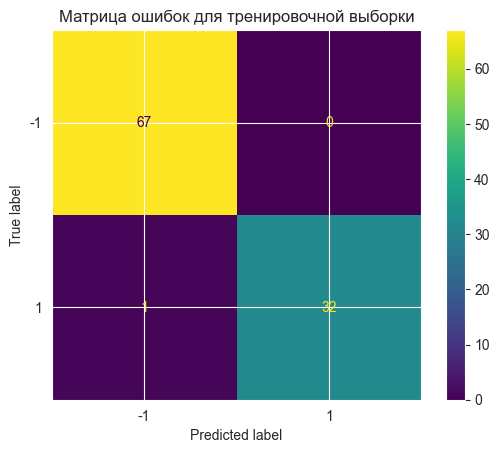

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


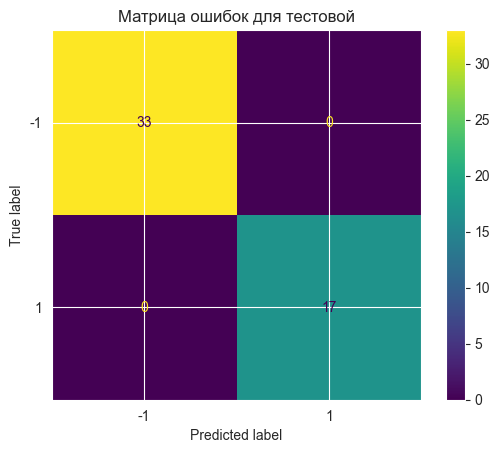

In [217]:
cntr_svm.try_model()

Всё тоже самое для mini batch, но у него поменяем шаг, чтобы не разошелся

In [218]:
svm_mini_batch = SupportVectorMachine(X_train, y_train, h=0.005, min_iterations=1000, strategy='mini-batch', batch_size=10) 
svm_mini_batch.fit()

array([ 1.35  , -2.0695,  3.04  ])


Уравнение гиперплоскости


$
 \\
 1.35 - 2.0695x_1 + 3.04x_2 = 0
$

Вновь считаем метрики

Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9696969696969697
f1: 0.9846153846153847

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


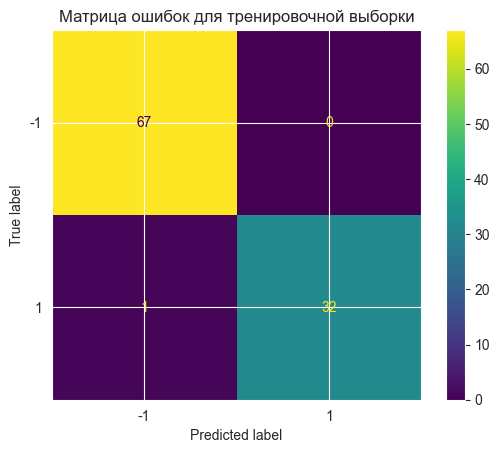

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


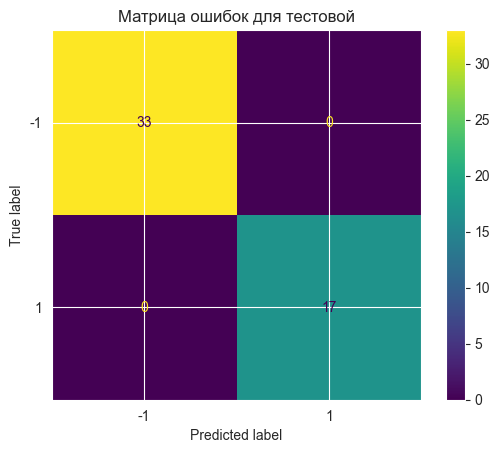

In [219]:
cntr_svm_mini_batch = Counter(X_train, X_test, y_train, y_test, svm_mini_batch)
cntr_svm_mini_batch.try_model()

Остался последний способ, реализованный у нас, это стохастический градиент спуск задаем те же параметры что и у mini-batch

In [220]:
svm_stochastic = SupportVectorMachine(X_train, y_train, h=0.005, min_iterations=1000, strategy='stochastic') 
svm_stochastic.fit()

array([ 0.895 , -1.0275,  1.4475])

Уравнение гиперплоскости


$
 \\
0.895 - 1.0275x_1 + 1.4475x_2 = 0
$

Метрики для стохастического

Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9696969696969697
f1: 0.9846153846153847

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


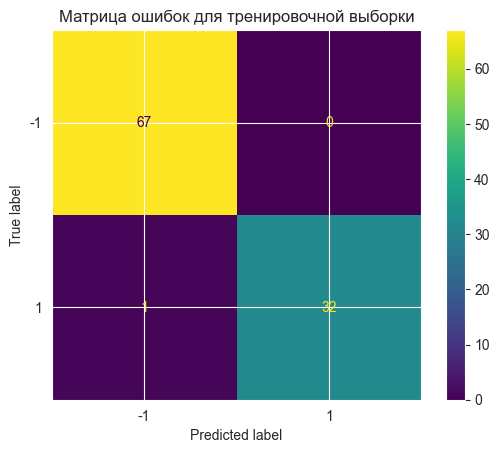

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


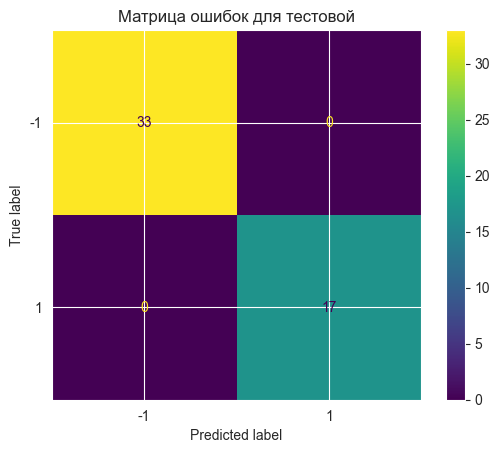

In [221]:
cntr_svm_stochastic = Counter(X_train, X_test, y_train, y_test, svm_mini_batch)
cntr_svm_stochastic.try_model()

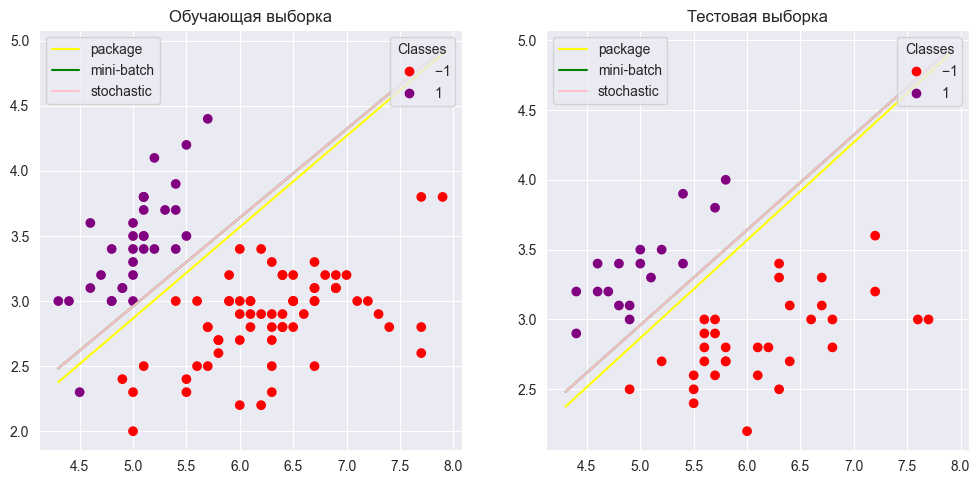

In [222]:
x1_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 50)

hyper_p_svm = cntr_svm.get_hyper_p_2_params(x1_range)
hyper_p_svm_mini_batch = cntr_svm_mini_batch.get_hyper_p_2_params(x1_range)
hyper_p_svm_stochastic = cntr_svm_stochastic.get_hyper_p_2_params(x1_range)

colors = ['red','green','blue','purple']



# Обучающая выборка
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)


scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors), marker="o")



ax.plot(x1_range, hyper_p_svm, c="yellow", label='package')
ax.plot(x1_range, hyper_p_svm_mini_batch, c="green", label='mini-batch')
ax.plot(x1_range, hyper_p_svm_stochastic, c="pink", label='stochastic')

ax.set_title('Обучающая выборка')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.legend()



#тестовая выборка
ax = fig.add_subplot(222)

scatter = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=matplotlib.colors.ListedColormap(colors), marker="o")


ax.plot(x1_range, hyper_p_svm, c="yellow", label='package')
ax.plot(x1_range, hyper_p_svm_mini_batch, c="green", label='mini-batch')
ax.plot(x1_range, hyper_p_svm_stochastic, c="pink", label='stochastic')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)

plt.legend()
plt.show()


По итогу метрики accuracy, precision и recall оказались одинаковыми, как следствие этого f0 тоже одинаковые

Визуально кажется, что все-таки пакетный градиентный спуск и mini-batch остается это узнать по функции ошибки 

In [234]:
print(svm.q)
print(svm_mini_batch.q)
print(svm_stochastic.q)


1.1263000000002972
6.298700000000171
15.489249999999922


У пакетного меньше всего ошибка, дальше будем продолжать работать с ним

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

In [231]:
svm = SupportVectorMachine(X_train,y_train,  h=0.005, min_iterations=10000) 
svm.fit()  #веса

array([ 9.53  , -4.6645,  4.9605])

Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9714285714285714
f1: 0.9855072463768116

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[65  0]
 [ 1 34]]


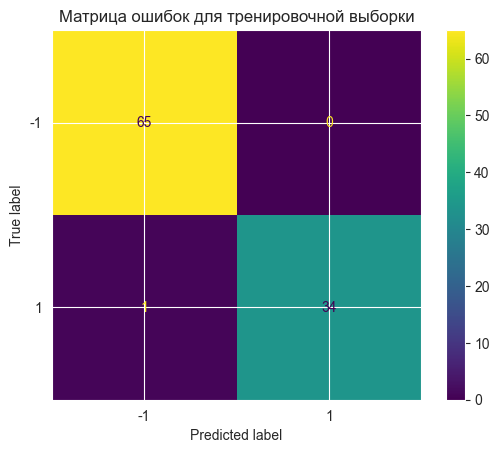

Матрица ошибок, полученная методом confusion_matrix
 [[35  0]
 [ 0 15]]


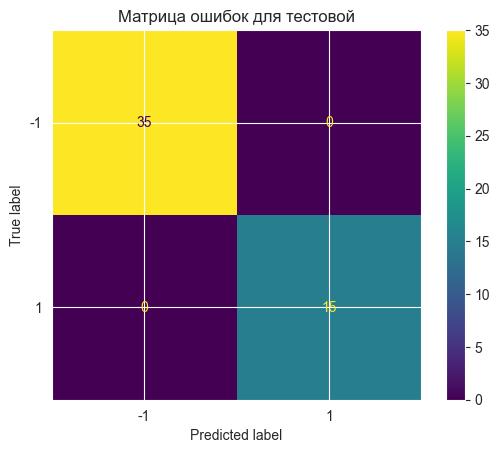

In [232]:
cntr_svm_stochastic = Counter(X_train, X_test, y_train, y_test, svm_mini_batch)
cntr_svm_stochastic.try_model()

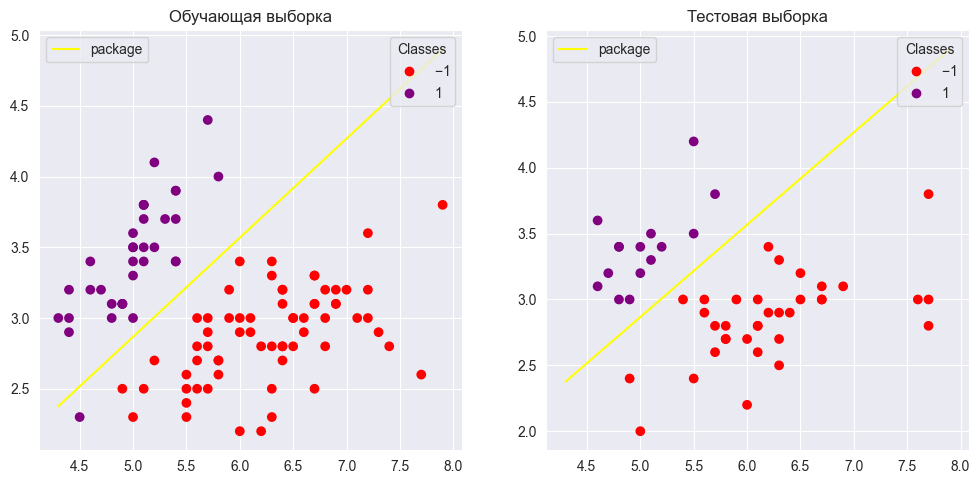

In [233]:
x1_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 50)

hyper_p_svm = cntr_svm.get_hyper_p_2_params(x1_range)

colors = ['red','green','blue','purple']



# Обучающая выборка
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)


scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors), marker="o")



ax.plot(x1_range, hyper_p_svm, c="yellow", label='package')


ax.set_title('Обучающая выборка')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.legend()



#тестовая выборка
ax = fig.add_subplot(222)

scatter = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=matplotlib.colors.ListedColormap(colors), marker="o")


ax.plot(x1_range, hyper_p_svm, c="yellow", label='package')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)

plt.legend()
plt.show()


In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=122)

Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9714285714285714
f1: 0.9855072463768116

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[65  0]
 [ 1 34]]


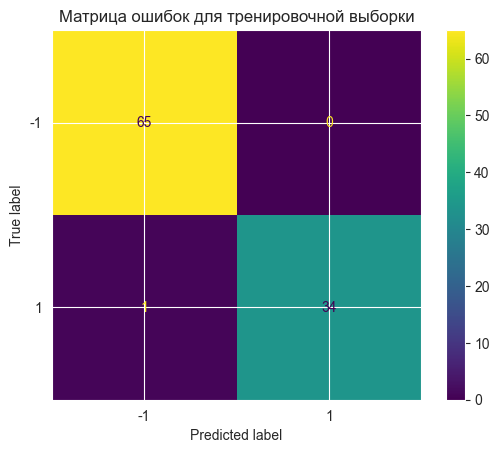

Матрица ошибок, полученная методом confusion_matrix
 [[35  0]
 [ 0 15]]


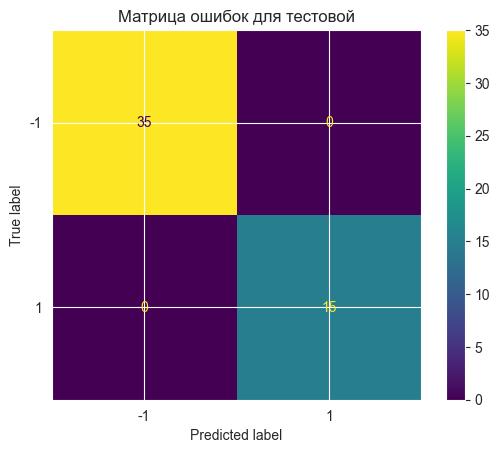

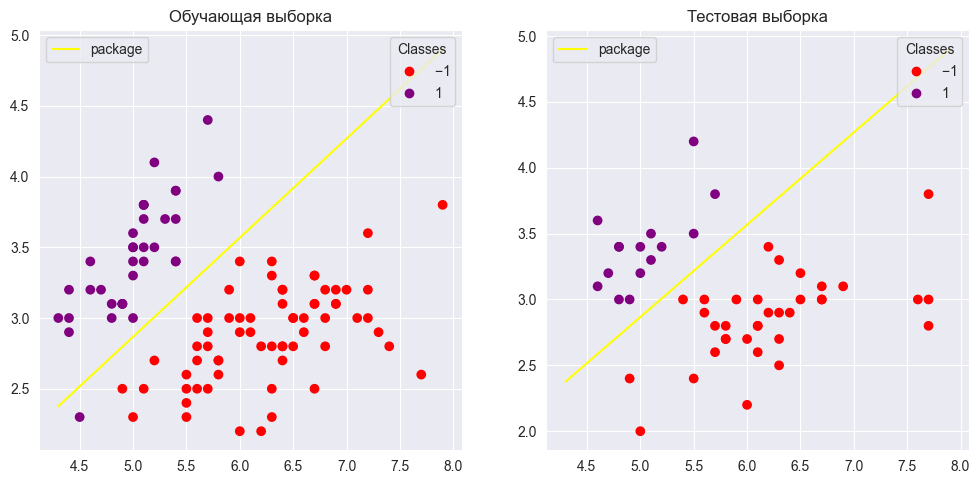

In [229]:
svm = SupportVectorMachine(X_train, y_train, min_iterations=10000)
svm.fit()  #веса
cntr_svm_stochastic = Counter(X_train, X_test, y_train, y_test, svm_mini_batch)
cntr_svm_stochastic.try_model()
x1_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 50)

hyper_p_svm = cntr_svm.get_hyper_p_2_params(x1_range)


colors = ['red', 'green', 'blue', 'purple']

# Обучающая выборка
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)

scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors), marker="o")

ax.plot(x1_range, hyper_p_svm, c="yellow", label='package')

ax.set_title('Обучающая выборка')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.legend()

#тестовая выборка
ax = fig.add_subplot(222)

scatter = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=matplotlib.colors.ListedColormap(colors), marker="o")

ax.plot(x1_range, hyper_p_svm, c="yellow", label='package')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)

plt.legend()
plt.show()